### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [61]:
#1

import numpy as np

data = np.load("hw_data\hw8_data_1.npy") #Importing the dataset

print(data.dtype.names) #Extracting the column names

def decompose(table, n):
    value = []
    for i in range(len(table)):
        if type(table[:][i][n]) == np.str_:
            value.append(str(table[:][i][n]))
        else: value.append(float(table[:][i][n]))
        
    return value

def subtract(a, b):
    value = []
    for i in range(len(a)):
        value.append(a[i] - b[i])
    return value


u         = decompose(data, 0) #I learned much later that there was a way to call specific columns with numpy arrays
g         = decompose(data, 1)
r         = decompose(data, 2)
i         = decompose(data, 3)
z         = decompose(data, 4)
specClass = decompose(data, 5)
redshift  = decompose(data, 6)
redErr    = decompose(data, 0)

ug = subtract(u,g) #With the method learned in the last comment, this would probably be redundant
gr = subtract(g,r)
ri = subtract(r,i)
iz = subtract(i,z)

print("Number of Regular Galaxies: ", specClass.count('GALAXY'))

print("Number of Quasars: ", specClass.count('QSO'))



('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Number of Regular Galaxies:  42808
Number of Quasars:  7192


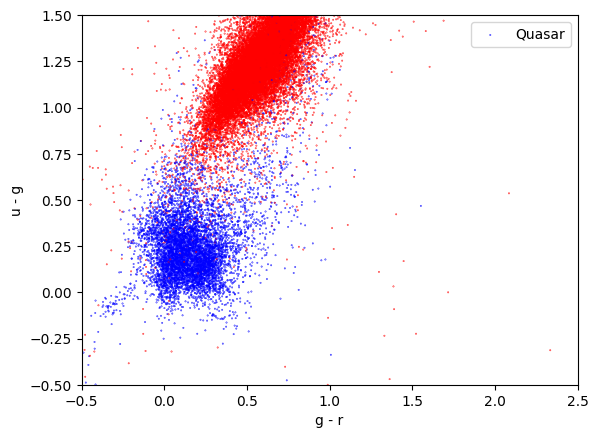

In [62]:
#2

import matplotlib.pyplot as plt

map = {'GALAXY': 'red', 'QSO': 'blue'}
map2 = {'GALAXY': 'Galaxy', 'QSO': 'Quasar'}

color = [map[x] for x in specClass]
labels = [map2[x] for x in specClass]

plt.scatter(gr, ug, c = color, s = 0.1);
plt.xlabel("g - r");
plt.ylabel("u - g");
plt.xlim(-0.5, 2.5);
plt.ylim(-0.5, 1.5);
plt.legend([labels[0], labels[1]]); #Could not get the legend to cooperate with the method i used to define the coloring


In [63]:
#3
from sklearn import model_selection as ms

X = np.column_stack((u, g, r, i, z, redshift))

map = {'GALAXY': 0, 'QSO': 1}
tag = [map[x] for x in specClass]

X_train, X_test, y_train, y_test = ms.train_test_split(X, tag, test_size = 0.2, random_state=42)

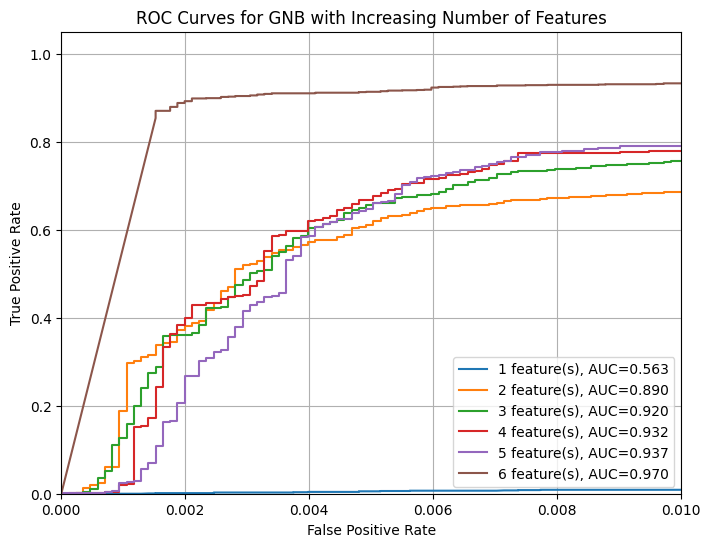

6 features: AUC = 0.9703


In [92]:
#4

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for i in range(1, X_train.shape[1] + 1):
    model = GaussianNB()
    model.fit(X_train[:, :i], y_train)
    
    # Index
    quasar_index = np.where(model.classes_ == 1)[0][0]
    
    # Predict Probability
    probs = model.predict_proba(X_test[:, :i])[:, quasar_index]
    
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{i} feature(s), AUC={roc_auc:.3f}')

plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GNB with Increasing Number of Features')
plt.legend()
plt.grid(True)
plt.show()

print(f'{i} features: AUC = {roc_auc:.4f}')


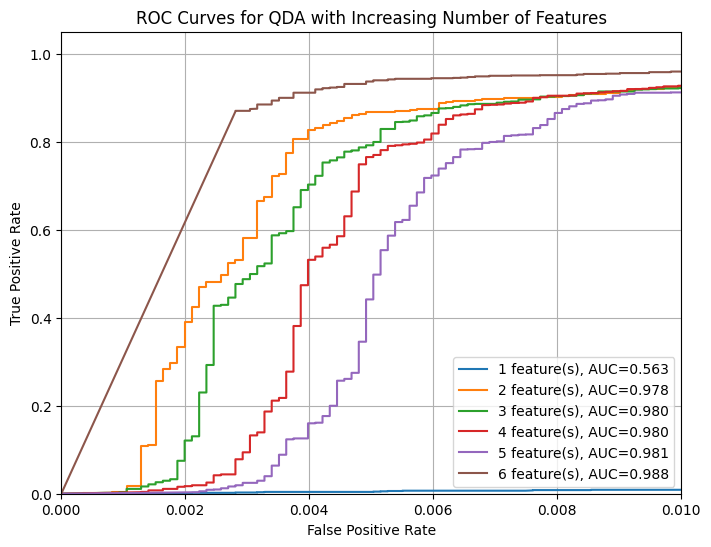

6 features: AUC = 0.9880


In [91]:
#5

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

plt.figure(figsize=(8, 6))

# Loop over increasing number of features
for i in range(1, X_train.shape[1] + 1):
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train[:, :i], y_train)
    
    # Index of Quasar
    quasar_index = np.where(model.classes_ == 1)[0][0]
    
    # Predict probability for Quasar
    probs = model.predict_proba(X_test[:, :i])[:, quasar_index]
    
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{i} feature(s), AUC={roc_auc:.3f}')

# Plot settings
plt.xlim(0, 0.01)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for QDA with Increasing Number of Features')
plt.legend()
plt.grid(True)
plt.show()

print(f'{i} features: AUC = {roc_auc:.4f}')

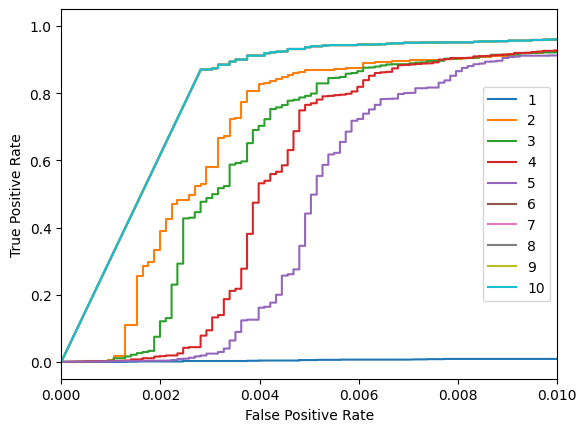

In [84]:
#6

from astroML.classification import GMMBayes
from sklearn.metrics import precision_recall_curve

a=[]
feat=[]
for i in range(1, 11):
    # Select the first 'i' components
    Xtrain_subset = X_train[:, :i]
    Xtest_subset = X_test[:, :i]

    # Create and fit the GMM bayes
    clf = GMMBayes()
    clf.fit(Xtrain_subset, y_train)

    # Make predictions
    y_pred = clf.predict(Xtest_subset)
    y_prob = clf.predict_proba(Xtest_subset)[:, 1]

    # Evaluate the model 
    accuracy = (y_pred == y_test).mean()
    a.append(accuracy)
    feat.append(i)
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=i
    plt.plot(fpr, tpr,label=i)
        

plt.xlim(0,.01)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

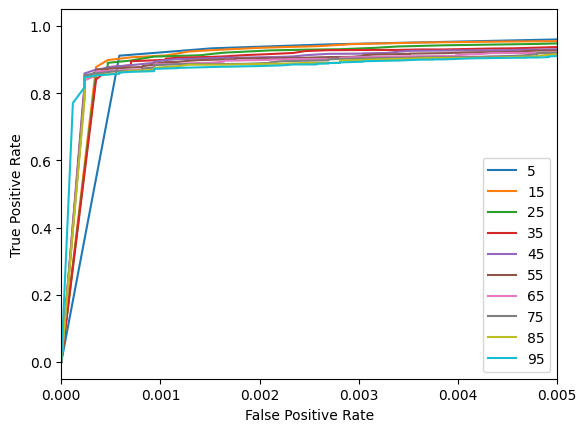

In [ ]:
#7

from sklearn.neighbors import KNeighborsClassifier
classifiers = []
predictions = []
Ncolors = np.arange(1, 5)
kvals = [5,15,25,35,45,55,65,75,85,95]
a=[]
feat=[]
for k in kvals:
# Select the first k neihbors
    
    Xtrain_subset = X_train
    Xtest_subset = X_test

    clf = KNeighborsClassifier(k)
    clf.fit(Xtrain_subset, y_train)

    # Predictions
    y_pred = clf.predict(Xtest_subset)
    y_prob = clf.predict_proba(Xtest_subset)[:, 1]

    # Evaluate
    accuracy = (y_pred == y_test).mean()
    a.append(accuracy)
    feat.append(k)
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=5
    plt.plot(fpr, tpr,label=k)
        

plt.xlim(0,.005)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

#This definitely doesnt look right

[0 1 2 8 6 3 9 4 7 5]
3


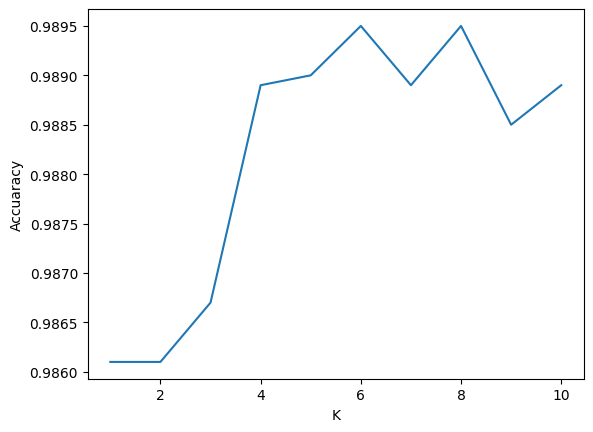

In [73]:
plt.plot(feat,a)
plt.xlabel("K")
plt.ylabel("Accuaracy")
print(np.argsort(a))
print(feat[2])

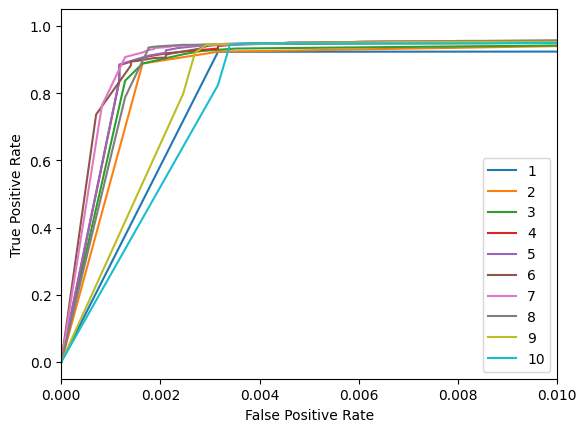

In [103]:
#8

from sklearn.tree import DecisionTreeClassifier
classifiers = []
predictions = []
Ncolors = np.arange(1, 5)
kvals = [5,15,25,35,45,55,65,75,85,95]

a=[]
feat=[]

for k in range(1,11):

    
    Xtrain_subset = X_train
    Xtest_subset = X_test

    tree = DecisionTreeClassifier(max_depth=k)
    tree.fit(Xtrain_subset, y_train)

    y_pred = tree.predict(Xtest_subset)
    y_prob = tree.predict_proba(Xtest_subset)[:, 1]

    accuracy = (y_pred == y_test).mean()
    a.append(accuracy)
    feat.append(k)
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    lables=5
    plt.plot(fpr, tpr,label=k)
        

plt.xlim(0,.01);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.legend();

[0 1 2 8 9 3 4 6 7 5]
5


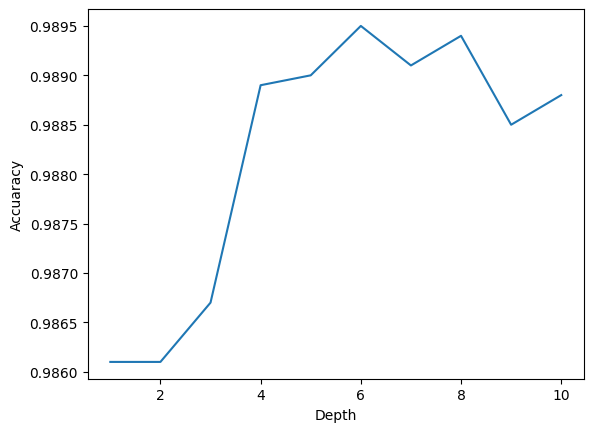

In [75]:
plt.plot(feat,a)
plt.xlabel("Depth")
plt.ylabel("Accuaracy")
print(np.argsort(a))
print(feat[4])

GaussianNB
QuadraticDiscriminantAnalysis
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


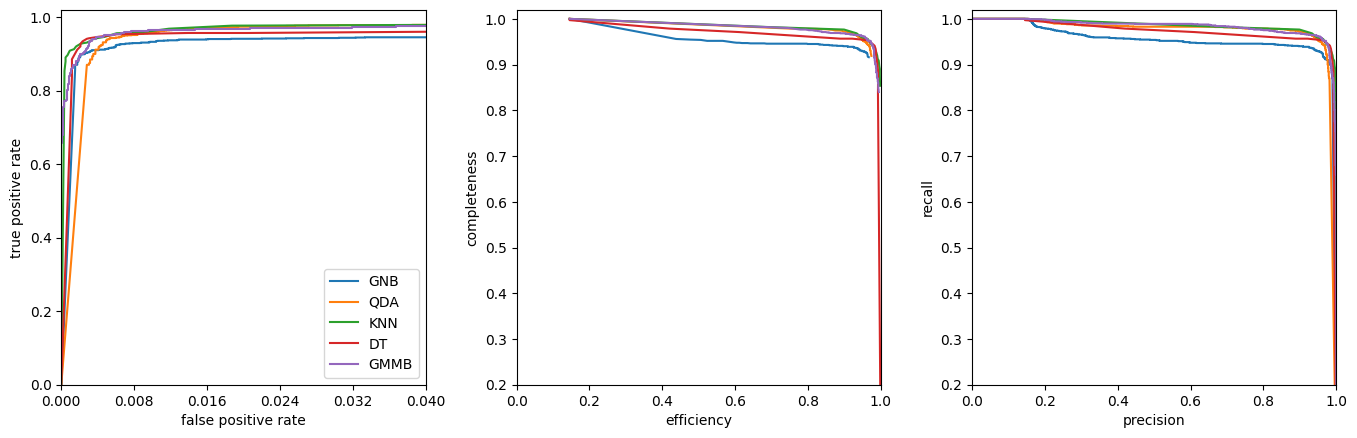

In [93]:
#9

from __future__ import print_function
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from astroML.utils import split_samples, completeness_contamination


# Fitting
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

names, probs = compute_models((GaussianNB, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=25)),
                              (DecisionTreeClassifier,
                               dict( max_depth=5)),
                              (GMMBayes, dict(n_components=2)))

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

labels = dict(GaussianNB='GNB',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB')

thresholds = np.linspace(0, 1, 1001)[:-1]

for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])
    
    ax3.plot(precision, recall, label=labels[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

ax3.set_xlabel('precision')
ax3.set_ylabel('recall')
ax3.set_xlim(0, 1.0)
ax3.set_ylim(0.2, 1.02)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

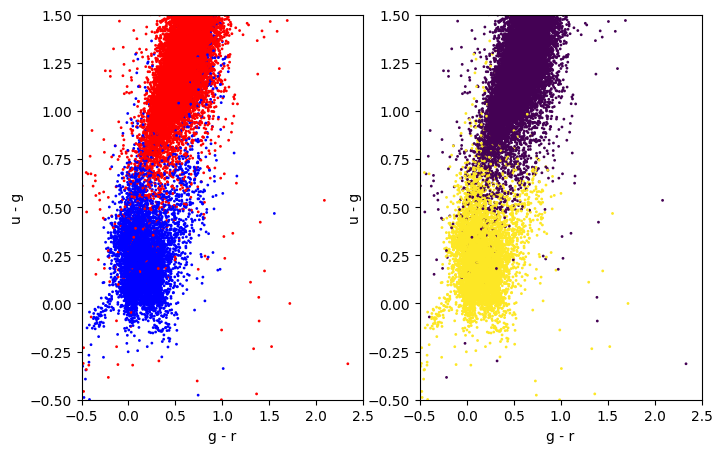

In [102]:
#10
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 5)) 

ax1.scatter(gr, ug, c = color, s = 1);
ax1.set_xlabel("g - r");
ax1.set_ylabel("u - g");
ax1.set_xlim(-0.5, 2.5);
ax1.set_ylim(-0.5, 1.5);




knc = KNeighborsClassifier(25)
knc.fit(X,tag)

preds = knc.predict(X)

ax2.scatter(gr, ug, c = preds, s = 1);
ax2.set_xlabel("g - r");
ax2.set_ylabel("u - g");
ax2.set_xlim(-0.5, 2.5);
ax2.set_ylim(-0.5, 1.5);

plt.show
